In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# read the data
data = pd.read_excel('training-Obama-Romney-tweets.xlsx',names = ['date','time','text','sentiment'],parse_cols = 4)
data = data.iloc[1:]
data['text'] = data['text'].values.astype('unicode')
data['date'] = data['date'].values.astype('str')
data['time'] = data['time'].values.astype('str')
# remove rows with mixed sentiment
data = data[data['sentiment'] < 2]
data.index = range(len(data))
print data.head()

                  date            time  \
0  2012-10-16 00:00:00  10:28:53-05:00   
1  2012-10-16 00:00:00  10:04:30-05:00   
2  2012-10-16 00:00:00  09:50:08-05:00   
3  2012-10-16 00:00:00  10:00:16-05:00   
4  2012-10-16 00:00:00  09:48:07-05:00   

                                                text sentiment  
0  Kirkpatrick, who wore a baseball cap embroider...         0  
1  #<e>obama</e> debates that Cracker Ass Cracker...         1  
2  @Hollivan @hereistheanswer  Youre missing the ...         0  
3  I was raised as a Democrat  left the party yea...        -1  
4  The <e>Obama camp</e> can't afford to lower ex...         0  


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5471 entries, 0 to 5470
Data columns (total 4 columns):
date         5471 non-null object
time         5471 non-null object
text         5471 non-null object
sentiment    5471 non-null object
dtypes: object(4)
memory usage: 213.7+ KB


In [4]:
data.describe()

,date,time,text,sentiment
count,5471,5471,5471,5471
unique,29,5139,5453,3
top,2012-10-16 00:00:00,nan,I just knew it...<e>Obama</e> was born in Indo...,-1
freq,1292,5,3,1922


In [5]:
import re

# remove punctuations
punc = ['\:','\;','\?','\$','\.','\(','\)']
cond_1 = re.compile('|'.join(punc))
data['text'] = data['text'].apply(lambda x : re.sub(cond_1,'',x))
# remove tags
tags = ['<a>','</a>','<e>','</e>']
cond_2 = re.compile("|".join(tags))
data['text'] = data['text'].apply(lambda x : re.sub(cond_2,'',x))

In [6]:
def extract_date(pattern,string):
    temp = re.match(pattern,string)
    if temp:
        return temp.group(1)
    else:
        return string
# clean date
date_format_1 = re.compile('\d+/(\d{2})/\d+')
date_format_2 = re.compile('\d+\-\d+\-(\d{2})')
date_format_3 = re.compile('(\d{2})\-[a-zA-Z]+\-\d+')
date_format = [date_format_1] + [date_format_2] + [date_format_3]

# remove whitespace
data['date'] = data['date'].apply(lambda x : x.replace(' ',''))

for i in date_format:
    data['date'] = data['date'].apply(lambda x: extract_date(i,x))

def converter(first,second):
    if first == 'AM':
        return second
    else:
        val = re.findall('(\d{1,2})',second)[0]
        if int(val) > 12:
            val = str(int(val) + 12)
        return re.sub('\d{1,2}',val,second,1)
    
def extract_time(pattern,string):

    temp = re.match(pattern,string)
    if temp:
        first = temp.group(1)
        second = temp.group(2)
        third = temp.group(3)
        
        if first is None and third is None:
            return second
        
        if first == 'AM' or first == 'PM':
            return converter(first,second)
        else:
            return converter(third,second)

# clean time
time_format_1 = re.compile('(AM|PM)?\s?(\d{1,2}:\d{1,2}:\d{1,2})\s?(AM|PM)?')

# remove whitespace
data['time'] = data['time'].apply(lambda x : x.replace(' ',''))

data['time'] = data['time'].apply(lambda x : extract_time(time_format_1,x))
data['time'] = pd.to_datetime(data['time'], format='%H:%M:%S')

In [53]:
# remove stopwords

-1    1922
 0    1896
 1    1653
Name: sentiment, dtype: int64


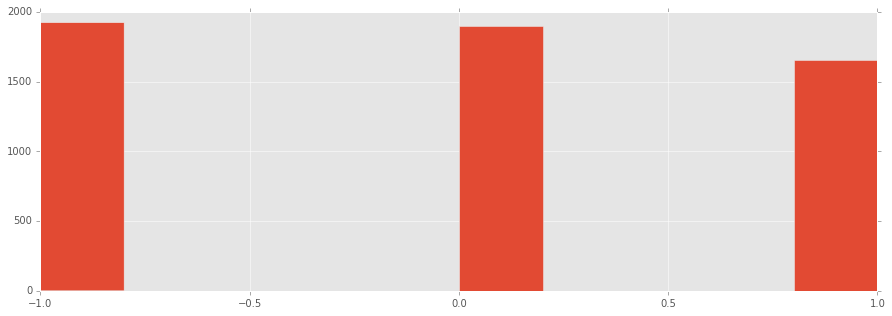

In [7]:
# distribution of sentiment
print data['sentiment'].value_counts()
data['sentiment'].hist()

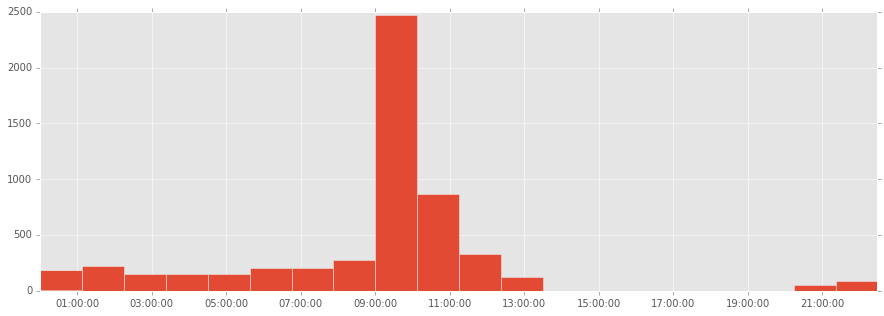

In [8]:
# tweets distribution over time
data['time'].hist(bins = 20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6bff3f78d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6bff1b3c50>]], dtype=object)

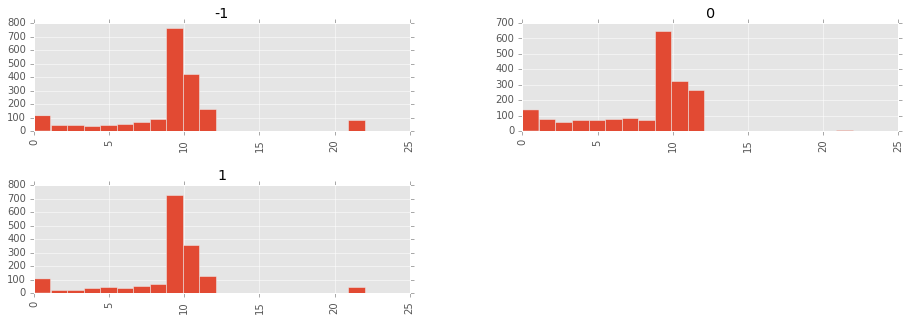

In [9]:
# plot sentiment over time
sentiment_val = data['sentiment'].unique()

data['time'].dt.hour.hist(by = data['sentiment'],bins = 20)

 1    327
-1    197
 0    170
Name: sentiment, dtype: int64
-1    25
 1    15
 0    15
Name: sentiment, dtype: int64


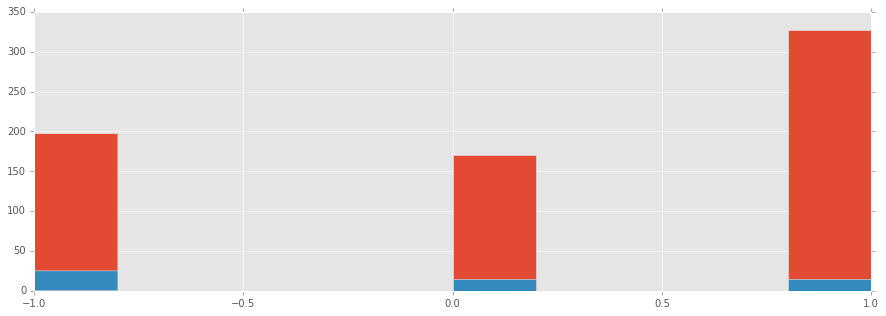

In [30]:
# sentiment distribution containing words
data[data['text'].str.contains('barack|obama')]['sentiment'].hist() # red
data[data['text'].str.contains('mitt|romney')]['sentiment'].hist() # blue
print data[data['text'].str.contains('barack|obama')]['sentiment'].value_counts()
print data[data['text'].str.contains('mitt|romney')]['sentiment'].value_counts()

In [32]:
data[:5]

,date,time,text,sentiment
0,16,1900-01-01 10:28:53,"Kirkpatrick, who wore a baseball cap embroider...",0
1,16,1900-01-01 10:04:30,#obama debates that Cracker Ass Cracker tonigh...,1
2,16,1900-01-01 09:50:08,@Hollivan @hereistheanswer Youre missing the ...,0
3,16,1900-01-01 10:00:16,I was raised as a Democrat left the party yea...,-1
4,16,1900-01-01 09:48:07,The Obama camp can't afford to lower expectati...,0


# Learning

In [40]:
import numpy as np

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier

# divide into train and test data
train_data,train_target = data['text'][:-500],data['sentiment'][:-500].astype(int)
test_data,test_target = data['text'][-500:],data['sentiment'][-500:].astype(int)

# create a pipeline
text_tfidf = Pipeline([('vect', CountVectorizer()),
                    ('tfidf',TfidfTransformer())])

# transform the data
train_data = text_tfidf.fit_transform(train_data)
test_data = text_tfidf.transform(test_data)

# naive Bayes
naive_clf = MultinomialNB().fit(train_data,train_target)
pred_val = naive_clf.predict(test_data)
print "Naive Bayes accuracy is {}".format(np.mean(pred_val == test_target))

# svm
svm_clf = LinearSVC().fit(train_data,train_target)
pred_val = svm_clf.predict(test_data)
print "Linear SVM accuracy is {}".format(np.mean(pred_val == test_target))

# sgd
sgd_clf = SGDClassifier().fit(train_data,train_target)
pred_val = sgd_clf.predict(test_data)
print "SGD classifier accuracy is {}".format(np.mean(pred_val == test_target))

Naive Bayes accuracy is 0.554
Linear SVM accuracy is 0.53
SGD classifier accuracy is 0.56


In [52]:
from sklearn import metrics